# Keep fiber hop delays similar to AP delays

AP delays are 2.5 and 5 ms, based on LTE release 8. Fiber optic hops keep around $10^{-3}$ ms if we don't introduce processing delay.
Thus, we incorporate processing delay such that we stay within similar orders of magnitude.

Assuming an $M/M/1$ queueing discipline and a vCPU processing rate of $\mu=1.26$ Gbps$=1.05\cdot10^5\frac{\text{paquets}}{\text{second}}$ (MTU=1500B) [1], we have as average service time:
$$
T = \frac{1/\mu}{1 - \lambda/\mu}
$$
which means service time must be $\mu \ge \lambda + 1/T$ if we want to stay above $T$. In our case we have $T\sim 10^{-3}$ secs.

## AP to M1s (example)
In this part we have $\lambda=10$ Gbps=$8.3\cdot10^5\frac{\text{paquets}}{\text{second}}$, which means we must have
$$
    \mu_a \ge 8.3\cdot10^5 + 1/10^{-3} > 8\mu
$$
which is equivalent to state that the an M1 switch must have at least a traffic switching power of 8 vCPUs.

Lets say we want to stay below $T=10ms$, then we need $\mu_a = N\mu < 8.3\cdot10^5\frac{p}{s} + 1/10^{-2}$.

In [25]:
print("𝜇_𝑎={}".format((8.3e5 + 1e2) / 1.05e5))

𝜇_𝑎=7.905714285714286


# vCPUs at each network level
Given the example above, we derive this snippet of code to obtain how many vCPUs we need on each layer of the network.

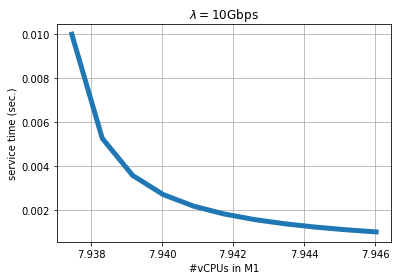

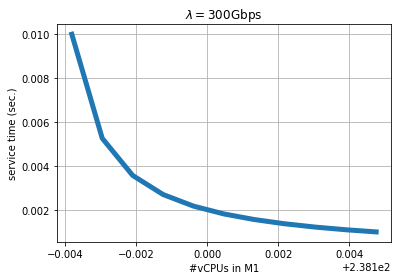

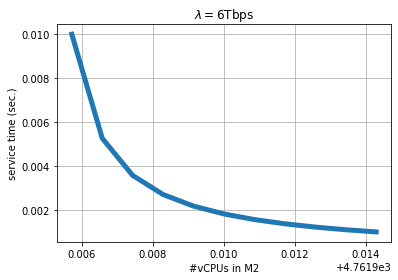

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Obtains the mus needed to stay between low_time and up_time
# both parameters are assumed to be in seconds
def calc_mus(low_time, up_time, lambda_, samples=10,
             vcpu_units=False, vcpu_mu=1.05e5):
    big_mu = lambda_ + 1/low_time
    little_mu = lambda_ + 1/up_time
    
    mus = [little_mu + i/samples * (big_mu - little_mu) for i in range(samples+1)]
    service_times = [1/mu / (1-lambda_/mu) for mu in mus]
    
    if vcpu_units:
        mus = [mu / vcpu_mu for mu in mus]
    
    return mus, service_times



lambda_access = 10 * 1.05e5 / 1.26 # 10Gbps
time_mus, service_delay = calc_mus(1e-3, 10e-3, lambda_access, 10, True)
plt.ylabel('service time (sec.)')
plt.xlabel('#vCPUs in M1')
plt.title('$\\lambda=10$Gbps')
plt.plot(time_mus, service_delay, linewidth=5)
plt.grid()
plt.show()

lambda_access_ring = 300 * 1.05e5 / 1.26 # 10Gbps
time_mus, service_delay = calc_mus(1e-3, 10e-3, lambda_access_ring, 10, True)
plt.ylabel('service time (sec.)')
plt.xlabel('#vCPUs in M1')
plt.title('$\\lambda=300$Gbps')
plt.plot(time_mus, service_delay, linewidth=5)
plt.grid()
plt.show()

lambda_agg_ring = 6000 * 1.05e5 / 1.26 # 10Gbps
time_mus, service_delay = calc_mus(1e-3, 10e-3, lambda_agg_ring, 10, True)
plt.ylabel('service time (sec.)')
plt.xlabel('#vCPUs in M2')
plt.title('$\\lambda=6$Tbps')
plt.plot(time_mus, service_delay, linewidth=5)
plt.grid()
plt.show()

This means we have following vCPU dedicated to switching, to stay between 1 and 10 ms of hop delay:


| level | #vCPUs |
|-------|--------|
| AAU-M1 | [7.938, 7.945] |
| access ring | 238.1 |
| aggregation ring | 4761.9 |

## Generate random service times
Script below generates random service times $T$ between 1 and 10ms. Since the curve does not differ for the different $\lambda$ values (we impose same service time in each case), it is enough to generate $T$s for $\lambda=10$Gbps.

In [64]:
import random
import csv

num_service_times = 100
service_times = []
mus, _ = calc_mus(1e-3, 10e-3, lambda_access, 10, False)
rand_mus = [random.uniform(mus[0], mus[-1]) for _ in range(num_service_times)]


with open('fiber_delays.csv', mode='w') as delays_file:
    delays_writer = csv.writer(delays_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    for mu in rand_mus:
        # store the time in miliseconds
        delays_writer.writerow([1/mu / (1 - lambda_access/mu) * 1e3])

### References
[1] P. Emmerich, D. Raumer, F. Wohlfart and G. Carle, "Performance characteristics of virtual switching," 2014 IEEE 3rd International Conference on Cloud Networking (CloudNet), Luxembourg, 2014, pp. 120-125.
doi: 10.1109/CloudNet.2014.6968979